In [70]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [73]:
!pip install yfinance

In [74]:
# Load historical stock data
# Example using yfinance
import yfinance as yf

symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2023-09-29'

data = yf.download(symbol, start=start_date, end=end_date)

# Use closing prices for prediction
df = pd.DataFrame(data)



[*********************100%%**********************]  1 of 1 completed


In [75]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.466448,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.777189,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.779430,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.112873,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.039341,237458000
...,...,...,...,...,...,...
2023-09-22,174.669998,177.080002,174.050003,174.789993,174.560013,56725400
2023-09-25,174.199997,176.970001,174.149994,176.080002,175.848328,46172700
2023-09-26,174.820007,175.199997,171.660004,171.960007,171.733749,64588900


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2200 entries, 2015-01-02 to 2023-09-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2200 non-null   float64
 1   High       2200 non-null   float64
 2   Low        2200 non-null   float64
 3   Close      2200 non-null   float64
 4   Adj Close  2200 non-null   float64
 5   Volume     2200 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 120.3 KB


In [77]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2.200000e+03
mean,81.046293,81.950083,80.189999,81.105591,79.191501,1.258215e+08
std,54.061302,54.705195,53.454781,54.101281,54.519902,6.803075e+07
min,22.500000,22.917500,22.367500,22.584999,20.798660,3.145820e+07
25%,34.821876,34.985624,34.695623,34.868751,32.591243,8.052320e+07
50%,52.120001,52.438749,51.688749,52.176250,50.178997,1.077101e+08
75%,135.932495,137.354996,134.115002,135.554996,134.408726,1.506370e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,6.488252e+08


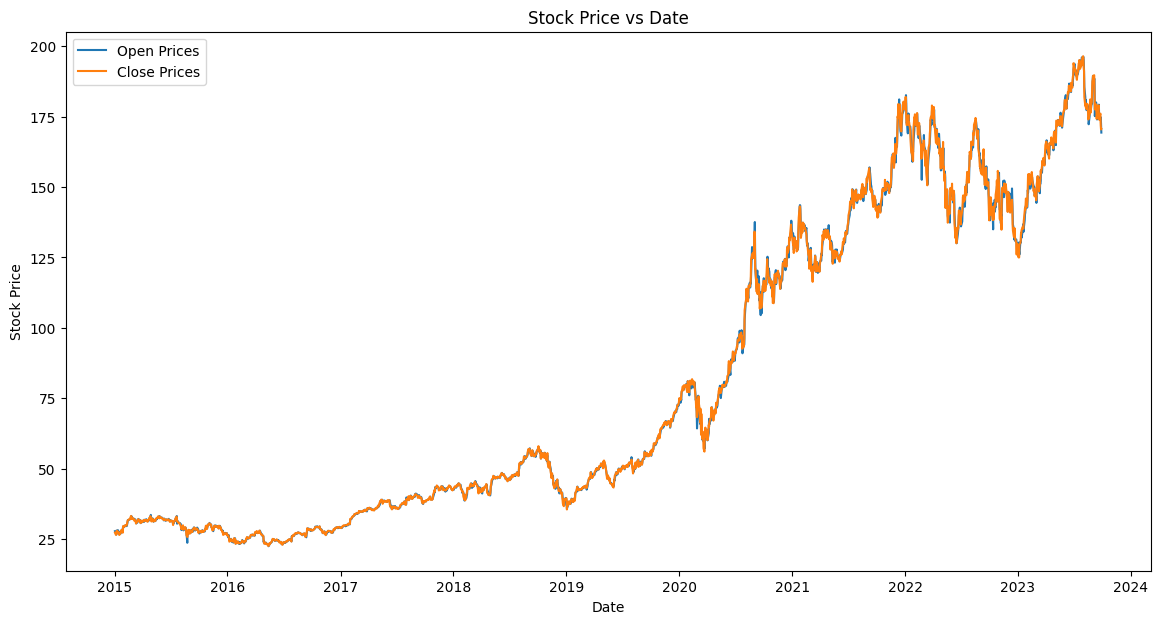

In [78]:
#plot for Open and Close price
plt.figure(figsize=(14, 7))
plt.plot(df.index,df['Open'], label='Open Prices')
plt.plot(df.index,df['Close'], label='Close Prices')
plt.title('Stock Price vs Date')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

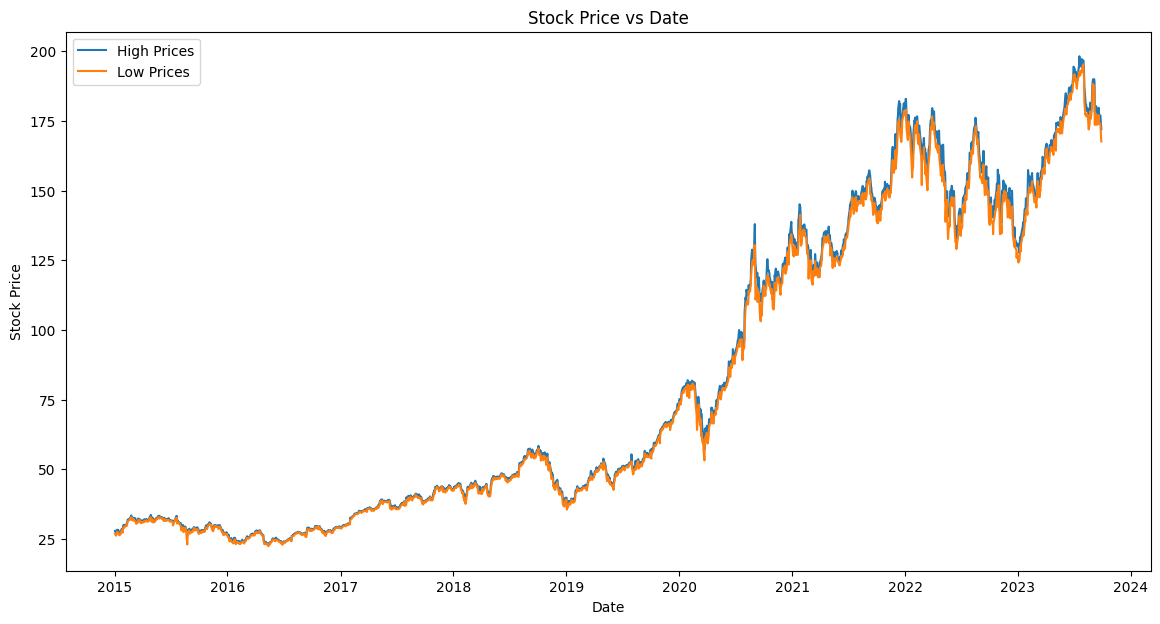

In [79]:
#plot for High and Low price
plt.figure(figsize=(14, 7))
plt.plot(df.index,df['High'], label='High Prices')
plt.plot(df.index,df['Low'], label='Low Prices')
plt.title('Stock Price vs Date')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

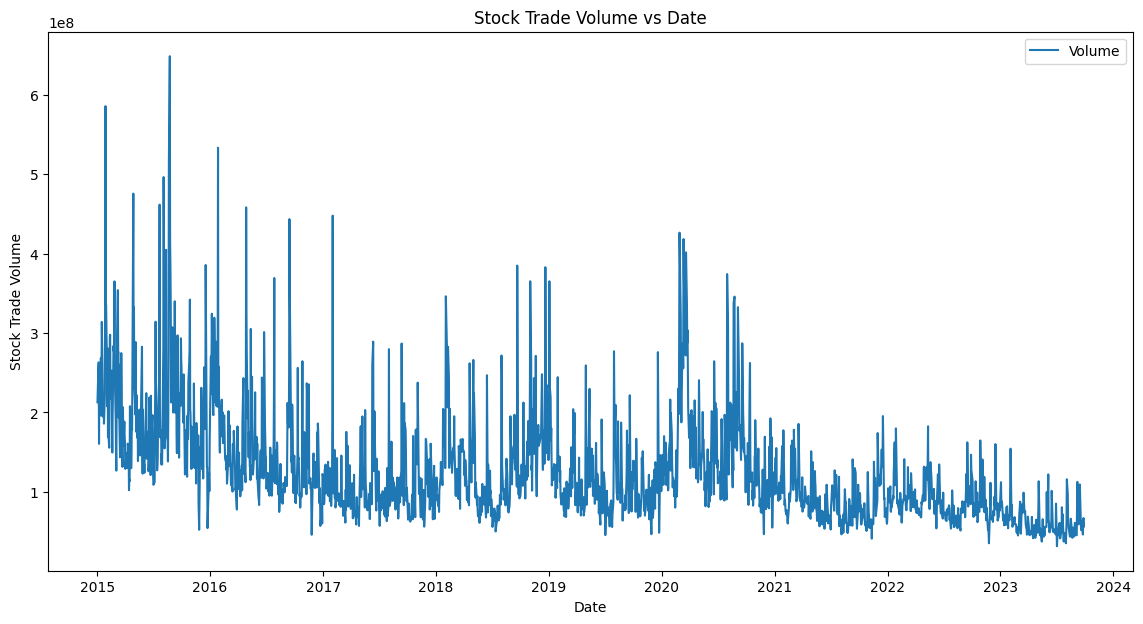

In [80]:
#plot for Open and Close price
plt.figure(figsize=(14, 7))
plt.plot(df.index,df['Volume'], label='Volume')
plt.title('Stock Trade Volume vs Date')
plt.xlabel('Date')
plt.ylabel('Stock Trade Volume')
plt.legend()
plt.show()

All the features **'Open', 'CLose', 'High', 'Low'** have the same trend so we can choose any one of them

In [81]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1, 1))

# Create sequences for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

seq_length = 5
X = create_sequences(df['Close'], seq_length)
y = df['Close'][seq_length:].values


In [82]:
#trai-test split
split_ratio = 0.7
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [83]:
#The LSTM model
model = Sequential()
model.add(LSTM(units=30,activation="relu", return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30,activation="sigmoid", return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model = model.fit(X_train, y_train, epochs=60, batch_size=64)
# model summmery
model.summary()

Epoch 1/60
24/24 [==============================] - 2s 5ms/step - loss: 0.0455
Epoch 2/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 3/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 4/60
24/24 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 5/60
24/24 [==============================] - 0s 6ms/step - loss: 3.1010e-04
Epoch 6/60
24/24 [==============================] - 0s 5ms/step - loss: 1.2908e-04
Epoch 7/60
24/24 [==============================] - 0s 6ms/step - loss: 1.2703e-04
Epoch 8/60
24/24 [==============================] - 0s 5ms/step - loss: 1.2133e-04
Epoch 9/60
24/24 [==============================] - 0s 5ms/step - loss: 1.1800e-04
Epoch 10/60
24/24 [==============================] - 0s 5ms/step - loss: 1.2170e-04
Epoch 11/60
24/24 [==============================] - 0s 5ms/step - loss: 1.1977e-04
Epoch 12/60
24/24 [==============================] - 0s 5ms/step - loss: 1.1912e-04
Epoch 13/60
24/24

In [84]:
loss = lstm_model.history['loss']


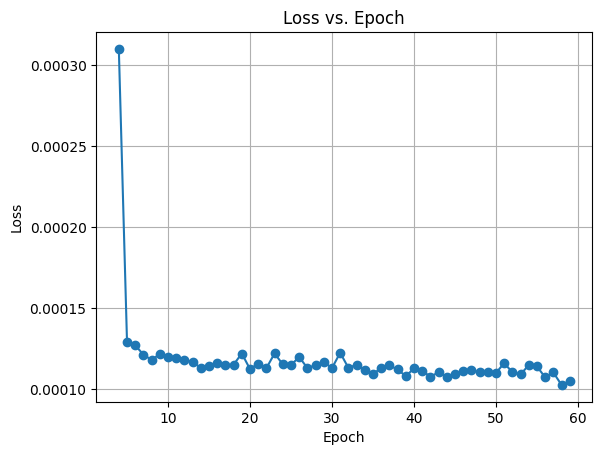

In [85]:
# Plotting the loss vs epoch
plt.plot(range(4, len(loss)), loss[4:], marker='o')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [86]:
#prediction ont he test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform y_test for evaluation
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Errors
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

mae= mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', rmse)

mape = mean_absolute_percentage_error(y_test, predictions)
print('Mean Absolute Percentage Error:', mape)

print('R2_score :',r2_score(y_test, predictions))

21/21 [==============================] - 0s 2ms/step
Mean Squared Error: 18.501801487551713
Mean Absolute Error: 3.398441031055132
Root Mean Squared Error: 4.301372047097497
Mean Absolute Percentage Error: 0.02199873741847878
R2_score : 0.9452985354534768


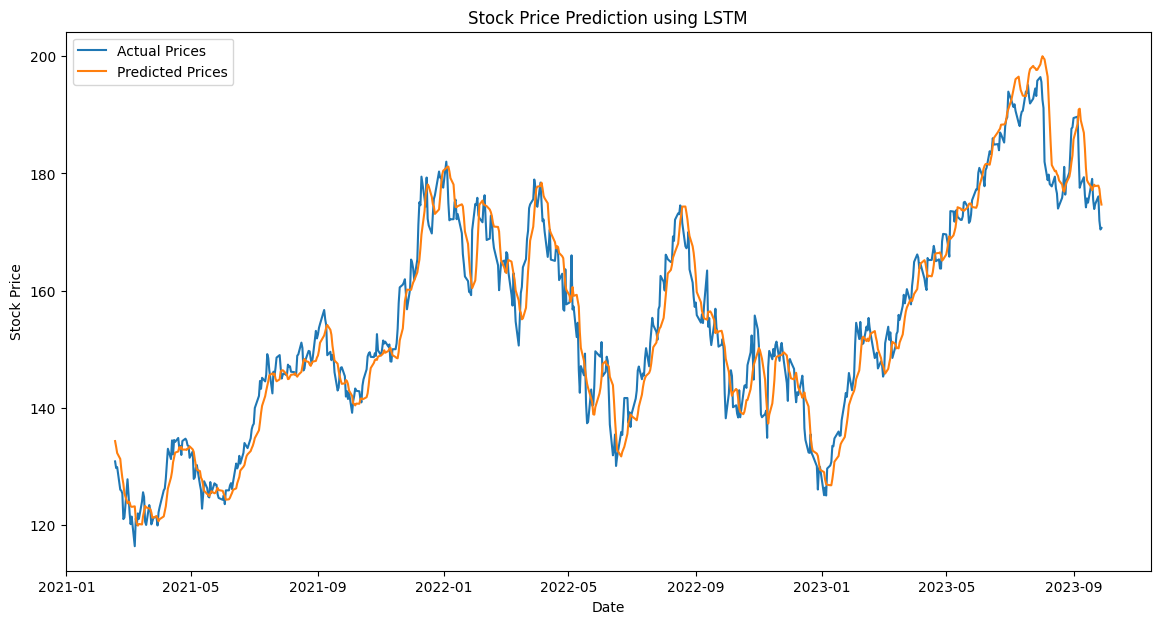

In [87]:
#plot for test vs predicted price
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [88]:
from datetime import datetime, timedelta

In [89]:
# Convert the start date to a datetime object and give an one day increamenet

forecast_start_date = pd.to_datetime(end_date) 

# Number of forecast days you want in the list
forecast_num_days = 15

# Generate a list of dates
forecast_days= [forecast_start_date + pd.DateOffset(days=i) for i in range(forecast_num_days)]

# Display the list of dates
print(forecast_days)


[Timestamp('2023-09-29 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-01 00:00:00'), Timestamp('2023-10-02 00:00:00'), Timestamp('2023-10-03 00:00:00'), Timestamp('2023-10-04 00:00:00'), Timestamp('2023-10-05 00:00:00'), Timestamp('2023-10-06 00:00:00'), Timestamp('2023-10-07 00:00:00'), Timestamp('2023-10-08 00:00:00'), Timestamp('2023-10-09 00:00:00'), Timestamp('2023-10-10 00:00:00'), Timestamp('2023-10-11 00:00:00'), Timestamp('2023-10-12 00:00:00'), Timestamp('2023-10-13 00:00:00')]


In [90]:
#forecasting future 10 days prices
His = X[-1:]
Future_Price  = []
for i in range(1,len(forecast_days)+1):
    forecast = model.predict(His)
    His = np.delete(His,0)
    His = np.append(His,forecast)
    His = His.reshape(1, -1)
    true_forecast = scaler.inverse_transform(forecast)
    Future_Price.append(true_forecast[0][0])
    print(His,true_forecast)
 


1/1 [==============================] - 0s 19ms/step
[[0.87542056 0.88284016 0.85914364 0.85034363 0.87482655]] [[174.6867]]
1/1 [==============================] - 0s 20ms/step
[[0.88284016 0.85914364 0.85034363 0.87482655 0.87536442]] [[174.78023]]
1/1 [==============================] - 0s 17ms/step
[[0.85914364 0.85034363 0.87482655 0.87536442 0.87441307]] [[174.61484]]
1/1 [==============================] - 0s 18ms/step
[[0.85034363 0.87482655 0.87536442 0.87441307 0.87169015]] [[174.1414]]
1/1 [==============================] - 0s 18ms/step
[[0.87482655 0.87536442 0.87441307 0.87169015 0.87488449]] [[174.6968]]
1/1 [==============================] - 0s 19ms/step
[[0.87536442 0.87441307 0.87169015 0.87488449 0.88122302]] [[175.79884]]
1/1 [==============================] - 0s 19ms/step
[[0.87441307 0.87169015 0.87488449 0.88122302 0.88235503]] [[175.99567]]
1/1 [==============================] - 0s 17ms/step
[[0.87169015 0.87488449 0.88122302 0.88235503 0.88367414]] [[176.225]]
1/1 [

In [91]:

Future_Price


[174.6867,
 174.78023,
 174.61484,
 174.1414,
 174.6968,
 175.79884,
 175.99567,
 176.225,
 176.58124,
 177.16347,
 177.74051,
 178.16357,
 178.65007,
 179.20753,
 179.81512]

In [92]:
# Inverse transform y 
y = scaler.inverse_transform(y.reshape(-1, 1))

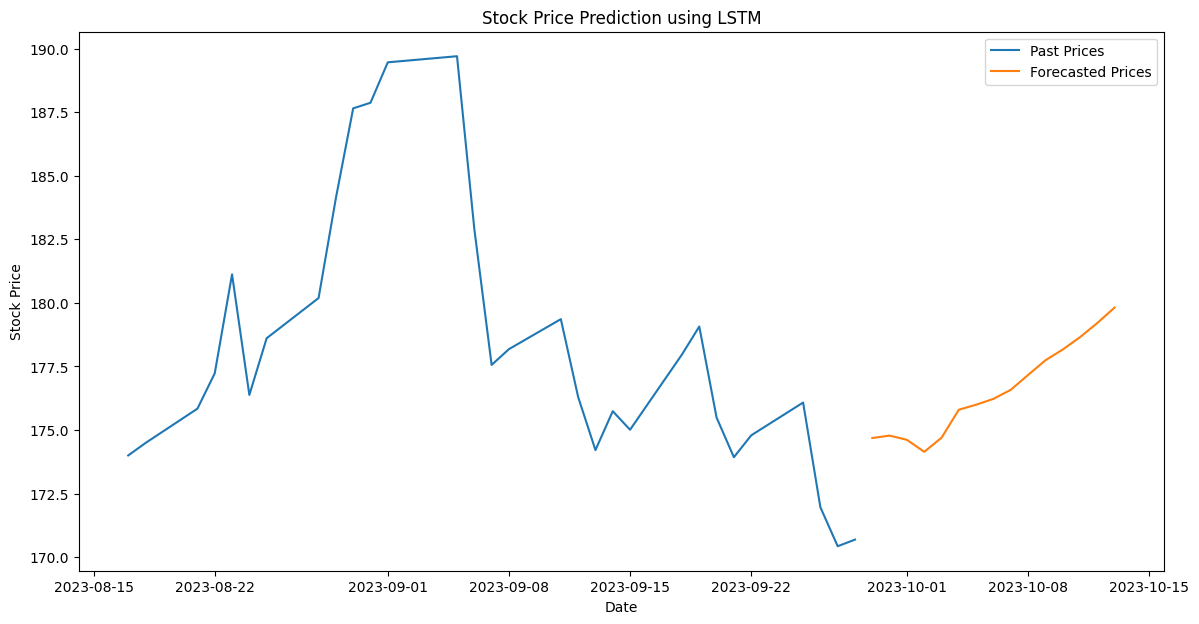

In [93]:
#plot for future 10 days prices 
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y[-30:]):], y[-30:], label='Past Prices')
plt.plot(forecast_days, Future_Price, label='Forecasted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()